# SAE embedding + DEC clustering + MLP classification: 
## from NME_DEC/decModel_wimgF_dualopt_descStats_wclusters.py

In [8]:
import sys
import os
sys.path.insert(0,'Z:/Cristina/Section3/NME_DEC')
sys.path.insert(0,'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels')
# pylint: skip-file
import sys
import os
import mxnet as mx
import numpy as np
import pandas as pd
import data
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging
import sklearn
from sklearn.manifold import TSNE
from utilities import *
try:
   import cPickle as pickle
except:
   import pickle
import gzip

# for visualization
from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [9]:
NME_nxgraphs = r'Z:\Cristina\Section3\breast_MR_NME_biological\NMEs_SER_nxgmetrics'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)

# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)           

#########
# shape input (798L, 427L)     
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))
normdynamic = (allNMEs_dynamic - allNMEs_dynamic.mean(axis=0)) / allNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)

print('Normalizing morphology {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (allNMEs_morphology - allNMEs_morphology.mean(axis=0)) / allNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)

print('Normalizing texture {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / allNMEs_texture.std(axis=0)
normtext.mean(axis=0)

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (allNMEs_stage1 - allNMEs_stage1.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

# define variables for DEC 
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)
combX_allNME[np.isnan(combX_allNME)] = 0.00001


Loading 792 leasions with nxGdiscfeatures of size = 326
Normalizing dynamic 792 leasions with features of size = 34
Normalizing morphology 792 leasions with features of size = 19
Normalizing texture 792 leasions with features of size = 44
Normalizing stage1 792 leasions with features of size = 100
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


##################################################################
##  Unsupervised learning in optimal LD space: Fitting aN MLP DUAL OPTIMIZATION
################################################################## 

Loading autoencoder of znum = 261, mu = 3 , post training DEC results
DEC train init AUC = 0.668322935235
DEC train max meanAuc_cv = 0.633240030529 $\pm$ 0.0435237751778
DEC validation AUC at max meanAuc_cv = 0.578620689655

... MLP fully coneected layer trained on Z_train tested on Z_test


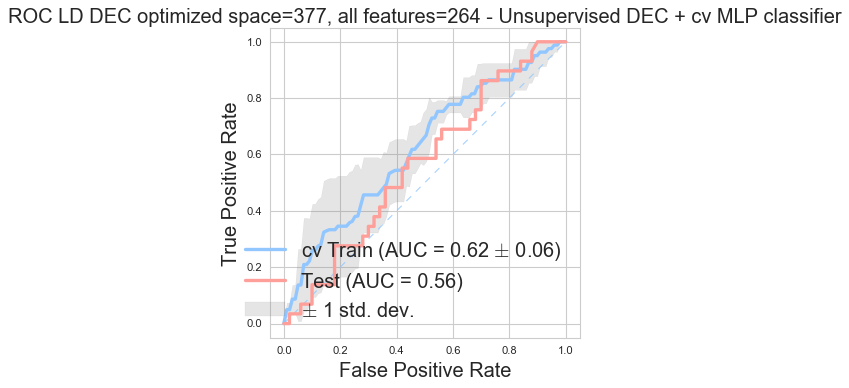

Loading autoencoder of znum = 261, mu = 7 , post training DEC results
DEC train init AUC = 0.662425727867
DEC train max meanAuc_cv = 0.656407134326 $\pm$ 0.0353211426111
DEC validation AUC at max meanAuc_cv = 0.615172413793

... MLP fully coneected layer trained on Z_train tested on Z_test


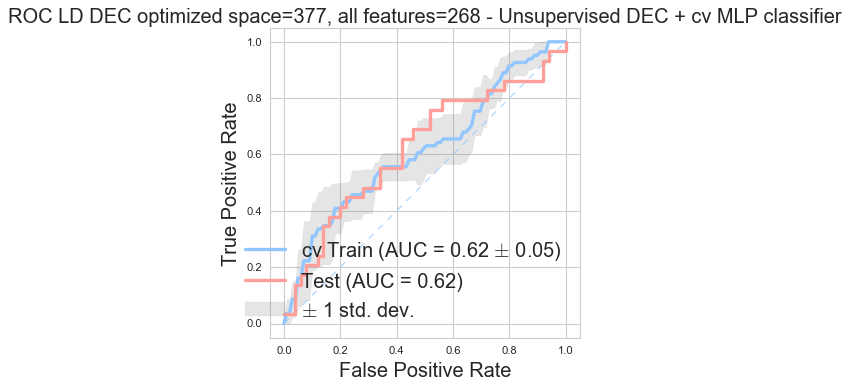

Loading autoencoder of znum = 261, mu = 8 , post training DEC results
DEC train init AUC = 0.701114081996
DEC train max meanAuc_cv = 0.637983594111 $\pm$ 0.0445968853647
DEC validation AUC at max meanAuc_cv = 0.522068965517

... MLP fully coneected layer trained on Z_train tested on Z_test


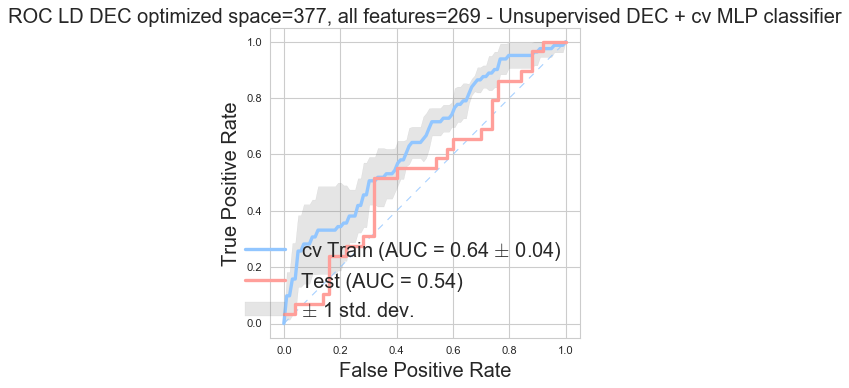

Loading autoencoder of znum = 261, mu = 10 , post training DEC results
DEC train init AUC = 0.698937908497
DEC train max meanAuc_cv = 0.66327929473 $\pm$ 0.0692789951047
DEC validation AUC at max meanAuc_cv = 0.644137931034

... MLP fully coneected layer trained on Z_train tested on Z_test


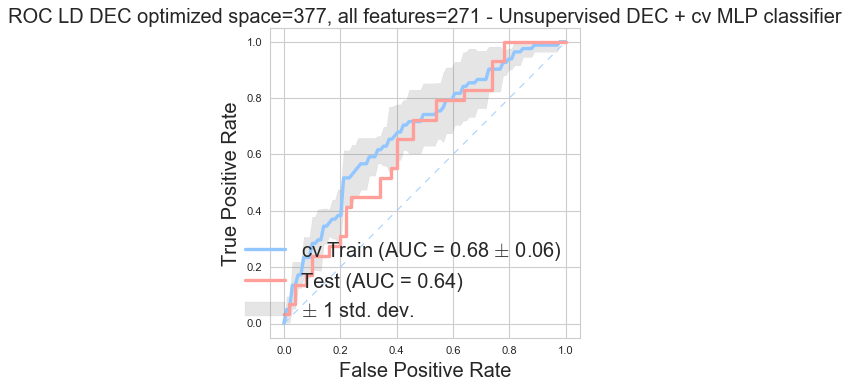

Loading autoencoder of znum = 261, mu = 12 , post training DEC results
DEC train init AUC = 0.67486631016
DEC train max meanAuc_cv = 0.661244800951 $\pm$ 0.0257128364466
DEC validation AUC at max meanAuc_cv = 0.660344827586

... MLP fully coneected layer trained on Z_train tested on Z_test


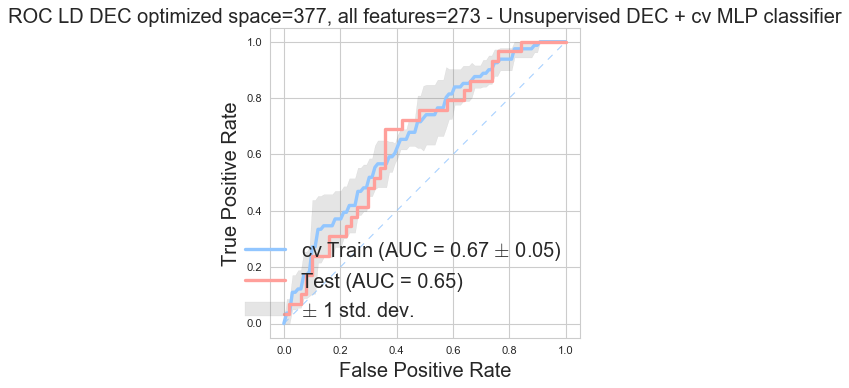

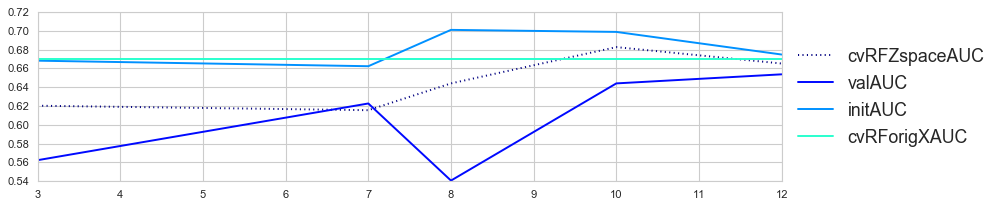

In [11]:
from decModel_wimgF_dualopt_descStats_wclusters import *
labeltype = 'wimgF_dualopt_descStats_wclusters' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_dualopt_descStats_saveparams_wclusters'
   
# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2]]
varying_mu = [3,7,8,10,12] #[int(np.round(var_mu)) for var_mu in np.linspace(3,12,10]

scoresM = np.zeros((len(latent_size),len(varying_mu),4))
scoresM_titles=[]

sns.set_color_codes("pastel")

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for ik,znum in enumerate(latent_size):
    cvRForigXAUC = []
    initAUC = []
    valAUC = []
    cvRFZspaceAUC = [] 
    normalizedMI = []
    for ic,num_centers in enumerate(varying_mu): 
        X = combX_allNME
        y = roi_labels
        y_train_roi_labels = np.asarray(y)

        print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
        dec_model = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)
          
        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)
        
        print('DEC train init AUC = {}'.format(outdict['meanAuc_cv'][0]))
        max_meanAuc_cv = outdict['meanAuc_cv'][-1]
        indmax_meanAuc_cv = outdict['meanAuc_cv'].index(max_meanAuc_cv)
        print r'DEC train max meanAuc_cv = {} $\pm$ {}'.format(max_meanAuc_cv,dec_model['std_auc'][indmax_meanAuc_cv])
        print('DEC validation AUC at max meanAuc_cv = {}'.format(outdict['auc_val'][indmax_meanAuc_cv]))
        
        #####################
        # extract Z-space from optimal DEC model
        #####################
        # saved output results
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mu']
        
        N = X.shape[0]
        all_iter = mx.io.NDArrayIter({'data': X}, batch_size=X.shape[0], shuffle=False,
                                                  last_batch_handle='pad')   
        ## extract embedded point zi 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        aDEC = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
        k1=[k for k,v in aDEC.ae_model.args.iteritems()]
        l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
        k2=[k for k,v in mxdec_args.iteritems()]

        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]

        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      

        # compute model-based best-pbestacci or dec_model['pbestacci']
        pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        #pbestacci = dec_model['pbestacci']
        
        # pool Z-space variables
        datalabels = np.asarray(y)
        dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 

        #####################
        # unbiased assessment: SPlit train/held-out test
        #####################
        # to compare performance need to discard unkown labels, only use known labels (only B or M)
        Z = dataZspace[datalabels!='K',:]
        y = datalabels[datalabels!='K']
      
        print '\n... MLP fully coneected layer trained on Z_train tested on Z_test' 
        sep = int(X.shape[0]*0.10)
        Z_test = Z[:sep]
        yZ_test = np.asanyarray(y[:sep]=='M').astype(int) 
        Z_train = Z[sep:]
        yZ_train = np.asanyarray(y[sep:]=='M').astype(int) 
       
        # We’ll load MLP using MXNet’s symbolic interface
        dataMLP = mx.sym.Variable('data')
        # MLP: two fully connected layers with 128 and 32 neurons each. 
        fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
        act1 = mx.sym.Activation(data=fc1, act_type="relu")
        fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
        act2 = mx.sym.Activation(data=fc2, act_type="relu")
        # data has 2 classes
        fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
        # Softmax output layer
        mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
        # create a trainable module on CPU     
        batch_size = 50
        mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
        # pass train/test data to allocate model (bind state)
        MLP_train_iter = mx.io.NDArrayIter(Z_train, yZ_train, batch_size, shuffle=False)
        mlp_model.bind(MLP_train_iter.provide_data, MLP_train_iter.provide_label)
        mlp_model.init_params()   
        mlp_model.init_optimizer()
        mlp_model_params = mlp_model.get_params()[0]
        
        # update parameters based on optimal found during cv Training
        from mxnet import ndarray
        params_dict = ndarray.load(os.path.join(save_to,'mlp_model_params_z{}_mu{}.arg'.format(znum,num_centers)))
        arg_params = {}
        aux_params = {}
        for k, value in params_dict.items():
            arg_type, name = k.split(':', 1)
            if arg_type == 'arg':
                arg_params[name] = value
            elif arg_type == 'aux':
                aux_params[name] = value
            else:
                raise ValueError("Invalid param file ")

        # order of params: [(128L, 266L),(128L,),(32L, 128L),(32L,),(2L, 32L),(2L,)]
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in mlp_model_params.iteritems()]
        k1=[k for k,v in mlp_model_params.iteritems()]
        l2=[v.asnumpy().shape for k,v in arg_params.iteritems()]
        k2=[k for k,v in arg_params.iteritems()]

        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    mlp_model_params[k1[ikparam]] = arg_params[k2[jkparam]]
        # upddate model parameters
        mlp_model.set_params(mlp_model_params, aux_params)
        
        #####################
        # ROC: Z-space MLP fully coneected layer for classification
        #####################
        figROCs = plt.figure(figsize=(5,5))    
        axaroc = figROCs.add_subplot(1,1,1)
        # Run classifier with cross-validation and plot ROC curves
        cv = StratifiedKFold(n_splits=5,random_state=3)
        # Evaluate a score by cross-validation
        tprs = []; aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        cvi = 0
        for train, test in cv.split(Z_train, yZ_train):
            # Pass cv data
            MLP_val_iter = mx.io.NDArrayIter(Z_train[test], yZ_train[test], batch_size)    
            # prob[i][j] is the probability that the i-th validation contains the j-th output class.
            prob_val = mlp_model.predict(MLP_val_iter)
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(yZ_train[test], prob_val.asnumpy()[:,1])
            # to create an ROC with 100 pts
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            # plot
            #axaroc.plot(fpr, tpr, lw=1, alpha=0.6) # with label add: label='cv %d, AUC %0.2f' % (cvi, roc_auc)
            cvi += 1
            
        axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.8)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        axaroc.plot(mean_fpr, mean_tpr, color='b',
                    label=r'cv Train (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=3, alpha=1)     
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
        
        ################
        # plot AUC on validation set
        ################
        MLP_heldout_iter = mx.io.NDArrayIter(Z_test, None, batch_size)   
        probas_heldout = mlp_model.predict(MLP_heldout_iter)
           
        # Compute ROC curve and area the curve
        fpr_val, tpr_val, thresholds_val = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
        auc_val = auc(fpr_val, tpr_val)
        axaroc.plot(fpr_val, tpr_val, color='r',
                    label=r'Test (AUC = %0.2f)' % (auc_val),lw=3, alpha=1)     

        axaroc.set_xlim([-0.05, 1.05])
        axaroc.set_ylim([-0.05, 1.05])
        axaroc.set_xlabel('False Positive Rate',fontsize=18)
        axaroc.set_ylabel('True Positive Rate',fontsize=18)
        axaroc.set_title('ROC LD DEC optimized space={}, all features={} - Unsupervised DEC + cv MLP classifier'.format(Z.shape[0],Z.shape[1]),fontsize=18)
        axaroc.legend(loc="lower right",fontsize=18)
        plt.show()
    
        ############# append to 
        cvRForigXAUC.append(0.67)
        initAUC.append(dec_model['meanAuc_cv'][0])
        cvRFZspaceAUC.append(np.mean(aucs))
        valAUC.append(auc_val)
        
        scoresM[ik,ic,0] = np.mean(aucs)
        scoresM_titles.append("DEC best mean_cvAUC")
        scoresM[ik,ic,1] = std_auc
        scoresM_titles.append("DEC best std_cvAUC")        
        scoresM[ik,ic,2] = auc_val
        scoresM_titles.append("DEC heal-out test AUC")        
 
        
    # plot latent space Accuracies vs. original
    colors = plt.cm.jet(np.linspace(0, 1, 16))
    fig2 = plt.figure(figsize=(12,6))
    #ax2 = plt.axes()
    sns.set_context("notebook")
    ax1 = fig2.add_subplot(2,1,1)
    ax1.plot(varying_mu, cvRFZspaceAUC, color=colors[0], ls=':', label='cvRFZspaceAUC')
    ax1.plot(varying_mu, valAUC, color=colors[2], label='valAUC')
    ax1.plot(varying_mu, initAUC, color=colors[4], label='initAUC')
    ax1.plot(varying_mu, cvRForigXAUC, color=colors[6], label='cvRForigXAUC')
    h1, l1 = ax1.get_legend_handles_labels()
    ax1.legend(h1, l1, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
     

##################################################################
## Find best performing parameters
################################################################## 

original input space = 523


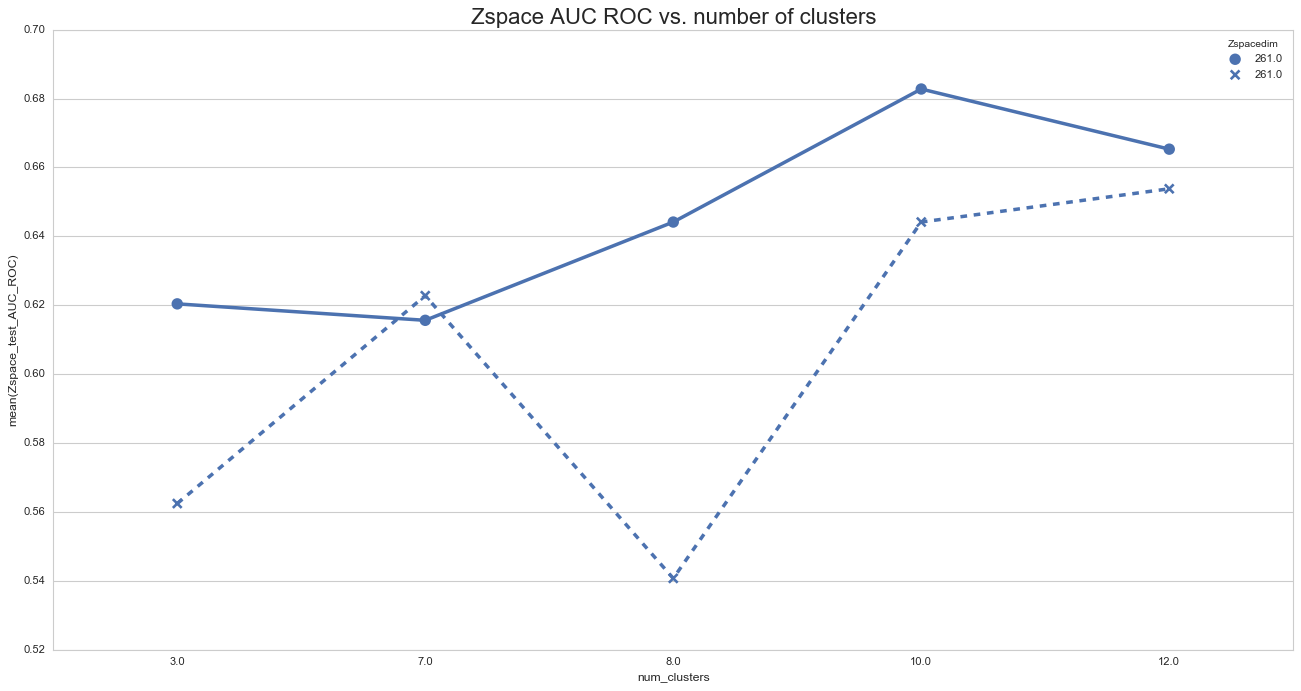

In [12]:
input_size = combX_allNME.shape[1]
print "original input space = %d" % input_size 
dict_aucZlatent = pd.DataFrame() 
for k,znum in enumerate(latent_size):
    for l,num_c in enumerate(varying_mu):
        dict_aucZlatent = dict_aucZlatent.append( pd.Series({'Zspacedim':znum, 
                                                             'Zspace_AUC_ROC': scoresM[k,l,0], 
                                                              'Zspace_test_AUC_ROC': scoresM[k,l,2], 
                                                             'num_clusters':num_c}), ignore_index=True)
fig2 = plt.figure(figsize=(20,10))
ax2 = plt.axes()
sns.set_context("notebook")  
sns.pointplot(x="num_clusters", y="Zspace_AUC_ROC", hue="Zspacedim", data=dict_aucZlatent, ax=ax2, size=0.05) 
sns.pointplot(x="num_clusters", y="Zspace_test_AUC_ROC", hue="Zspacedim", data=dict_aucZlatent, ax=ax2, size=0.05, markers=["x","x","x","x"],linestyles=["--","--","--","--"]) 
ax2.xaxis.set_label('# clusters')
ax2.yaxis.set_label('Zspace AUC ROC')
ax2.set_title('Zspace AUC ROC vs. number of clusters',fontsize=20)



In [14]:
# plot box plots
dict_aucZlatent['Zspacedim_cats'] = pd.Series(dict_aucZlatent['Zspacedim'], dtype="category")
dict_aucZlatent['num_clusters_cats'] = pd.Series(dict_aucZlatent['num_clusters'], dtype="category")
print dict_aucZlatent

   Zspace_AUC_ROC  Zspace_test_AUC_ROC  Zspacedim  num_clusters  \
0        0.620381             0.562414        261             3   
1        0.615605             0.622759        261             7   
2        0.644135             0.540690        261             8   
3        0.682757             0.644138        261            10   
4        0.665293             0.653793        261            12   

  Zspacedim_cats num_clusters_cats  
0            261                 3  
1            261                 7  
2            261                 8  
3            261                10  
4            261                12  


In [17]:
# find best performing by the average of broth train and test performance
max_aucZlatent = np.max(dict_aucZlatent[["Zspace_AUC_ROC", "Zspace_test_AUC_ROC"]].mean(axis=1))
indmax_meanAuc_cv = dict_aucZlatent[["Zspace_AUC_ROC", "Zspace_test_AUC_ROC"]].mean(axis=1) == max_aucZlatent
print "\n================== Best average train/test perfomance parameters:" 
bestperf_params = dict_aucZlatent[indmax_meanAuc_cv]
print bestperf_params

################################################################## 
Zspacedim_best = int(bestperf_params.iloc[0]['Zspacedim'])
num_clusters_best = int(bestperf_params.iloc[0]['num_clusters'])


================== Best average train/test perfomance parameters:
   Zspace_AUC_ROC  Zspace_test_AUC_ROC  Zspacedim  num_clusters  \
3        0.682757             0.644138        261            10   

  Zspacedim_cats num_clusters_cats  
3            261                10  


## t-SNE: Visualizing Clusters

In [22]:
def plot_embedding_unsuper_local(Z_tsne, y_tsne, ax, title=None, legend=True, withClustersImg=True):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib import offsetbox
    from matplotlib.offsetbox import TextArea, AnnotationBbox
    
    x_min, x_max = np.min(Z_tsne, 0), np.max(Z_tsne, 0)
    Z_tsne = (Z_tsne - x_min) / (x_max - x_min)

    # process labels 
    classes = [str(c) for c in np.unique(y_tsne)]
    #classes.remove('K_N/A')
    colors=plt.cm.winter(np.linspace(0,1,len(classes))) # plt.cm.gist_rainbow
    c_patchs = []
    greyc_U = np.array([0.5,0.5,0.5,0.5])
    for k in range(len(classes)):
        if(str(classes[k])!='K'):
            c_patchs.append(mpatches.Patch(color=colors[k], label=classes[k]))
        else:
            c_patchs.append(mpatches.Patch(color=greyc_U, label='unknown'))

    for i in range(Z_tsne.shape[0]):
        for k in range(len(classes)):
            if str(y_tsne[i])==classes[k]: 
                colori = colors[k]     
                
        if(str(y_tsne[i])!='K'):
            plt.text(Z_tsne[i, 0], Z_tsne[i, 1], str(y_tsne[i]), color=colori,
                     fontdict={'weight': 'bold', 'size': 10})
        else:        
            #print('{}..{}'.format(i,str(named_y[i])))
            plt.text(Z_tsne[i, 0], Z_tsne[i, 1], '.', color=greyc_U,
                 fontdict={'weight': 'bold', 'size': 32}) 
                     
            
    if(legend):
        plt.legend(handles=c_patchs, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':14})
      
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title is not None:
        plt.title(title)

Loading autoencoder of Zspacedim_best = 261, mu = 3 , post training DEC results
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 792 / 792
[t-SNE] Mean sigma: 0.062067
[t-SNE] Iteration 25: error = 18.4273479, gradient norm = 0.2065084
[t-SNE] Iteration 50: error = 19.0062335, gradient norm = 0.1797677
[t-SNE] Iteration 75: error = 19.2247727, gradient norm = 0.1839585
[t-SNE] Iteration 100: error = 19.4967327, gradient norm = 0.1701887
[t-SNE] KL divergence after 100 iterations with early exaggeration: 19.496733
[t-SNE] Iteration 125: error = 1.9974145, gradient norm = 0.0069315
[t-SNE] Iteration 150: error = 1.9569115, gradient norm = 0.0020106
[t-SNE] Iteration 175: error = 1.9493985, gradient norm = 0.0018999
[t-SNE] Iteration 200: error = 1.9472919, gradient norm = 0.0018621
[t-SNE] Iteration 225: error = 1.9467296, gradient norm = 0.0018429
[t-SNE] Iteration 250: error = 1.9465764, gradient norm = 0.0018375
[t-SNE] Iteration 275: error

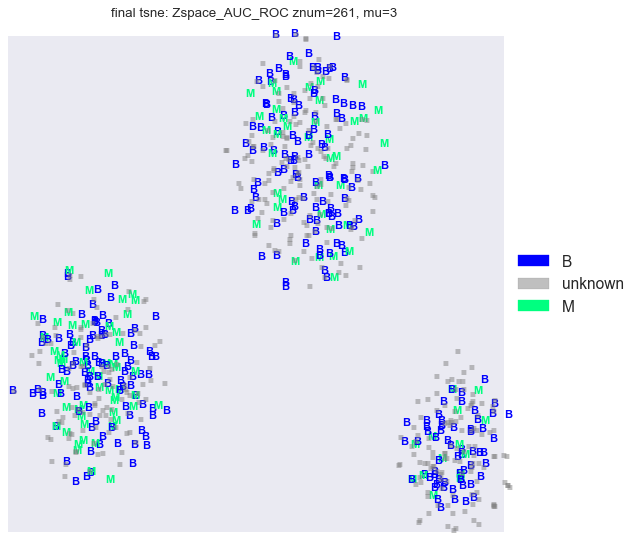

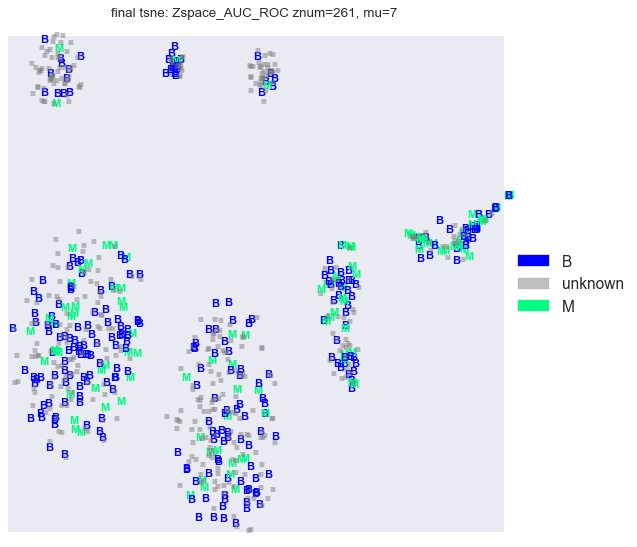

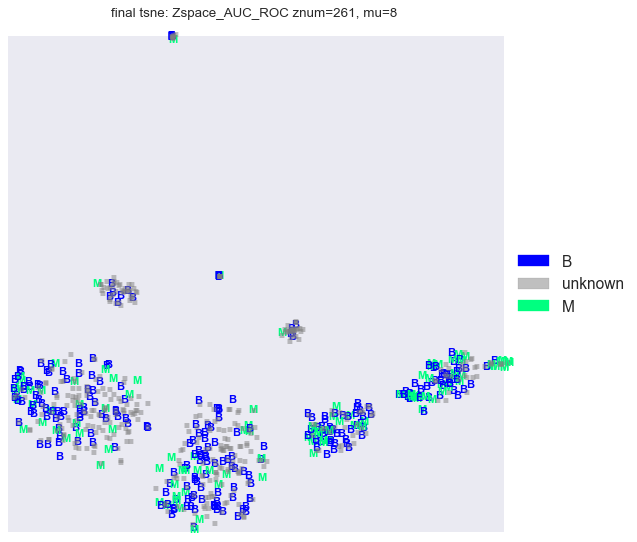

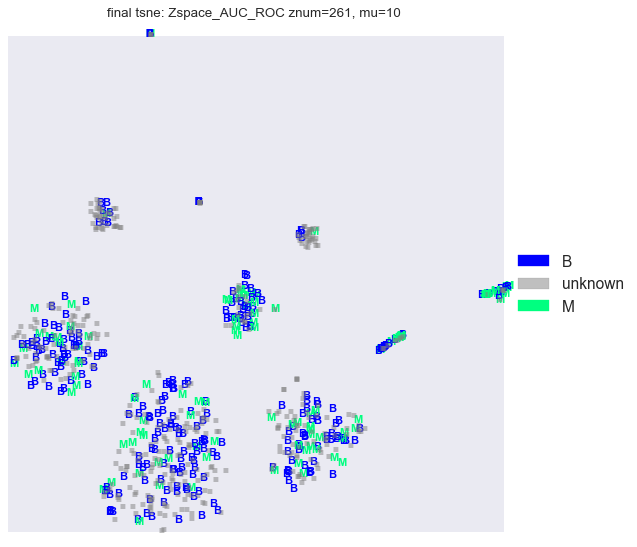

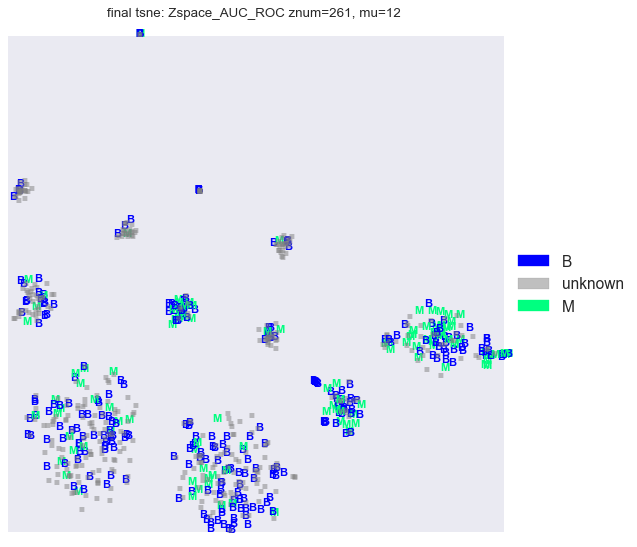

In [23]:
from decModel_wimgF_dualopt_descStats_wclusters import *
labeltype = 'wimgF_dualopt_descStats_wclusters' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_dualopt_descStats_saveparams_wclusters'

# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2]]
varying_mu = [3,7,8,10,12] #[int(np.round(var_mu)) for var_mu in np.linspace(3,12,10]

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for Zspacedim_best in latent_size:
    for num_clusters_best in varying_mu:

        print('Loading autoencoder of Zspacedim_best = {}, mu = {} , post training DEC results'.format(Zspacedim_best,num_clusters_best))
        
        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)
          
        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)
            
        #####################
        # extract Z-space from optimal DEC model
        #####################
        # saved output results
        X = combX_allNME
        y = roi_labels
        
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mu']
        
        N = X.shape[0]
        all_iter = mx.io.NDArrayIter({'data': X}, 
                                     batch_size=X.shape[0],
                                     shuffle=False,
                                     last_batch_handle='pad')   
        ## extract embedded point zi 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        aDEC = DECModel(mx.cpu(), X, num_clusters_best, 1.0, Zspacedim_best, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
        k1=[k for k,v in aDEC.ae_model.args.iteritems()]
        l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
        k2=[k for k,v in mxdec_args.iteritems()]
        
        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]
        
        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      
        
        # compute model-based best-pbestacci or dec_model['pbestacci']
        pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        #pbestacci = dec_model['pbestacci']
        
        # pool Z-space variables
        dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 
        
        figtsne = plt.figure(figsize=(8,8))
        axtsne = figtsne.add_subplot(1,1,1)
                    
        tsne = TSNE(n_components=2, perplexity=15, learning_rate=125,
             init='pca', random_state=0, verbose=2, method='exact')
        
        Z_tsne = tsne.fit_transform(zbestacci)   
        y_tsne = y #dec_model['named_y']
        
        # plot
        #plot_embedding_unsuper_NMEdist_intenh(Z_tsne, named_y, axtsne, title='final tsne: Zspace_AUC_ROC znum={}, mu={} \n'.format(Zspacedim_best,num_clusters_best), legend=True)
        plot_embedding_unsuper_local(Z_tsne, y_tsne, axtsne, 
                                     title='final tsne: Zspace_AUC_ROC znum={}, mu={} \n'.format(Zspacedim_best,num_clusters_best), 
                                     legend=True, withClustersImg=False)
        


    